The year my Mom moved in down the street from us, my husband tried to get some local property tax appeal company to reduce her assessment. They refused, saying they thought there wasn't a case.

The next year, she got a postcard from that same company: they would appeal her case and split the savings with her 50/50. Who wants to give up 50% of their tax savings? Plus, I was miffed from the prior year. I decided to try and appeal myself. Success!

<span class="vocabulary" title="A tool for automated testing of web applications, written in Java. I use the Python bindings."><a href="https://selenium-python.readthedocs.io/">Selenium</a></span> via Python bindings was used to pull the data from the web, and <a href="https://www.statsmodels.org">statsmodels</a>, with an interface that resembles R, was used to make the model.
<!-- TEASER_END -->


## What's the goal?

When you contest your assessment, you're supposed to identify comparable properties that have lower assessed values than yours. This bolsters the case that your property has been assessed too high. Our goal is to identify the most persuasive properties to use (if they exist). To do that, we need to know how Cook County assesses properties.

Actually, as of tax year 2018, we know the Cook County model is <span class="vocabulary" title="A linear regression but first you take the log of the y-value (endogenous variable).">log-linear</span>. Here is <a href="http://www.cookcountyassessor.com/Office/News.aspx?id=457">the announcement (no https)</a>, but they don't publish the actual regression coefficients. The announcement was probably a step toward transparency: the prior year there was an <a href="https://www.chicagotribune.com/news/watchdog/taxdivide/">investigative report by the Chicago Tribune and ProPublica</a> that probably cost the commissioner his seat in the most recent election.

This blog presents both a linear model, which I used to successfully appeal Mom's taxes last year, and a log-linear model, which Cook County says it started using as of May 2018. It is an executable Jupyter notebook (<a href="https://github.com/tanyaschlusser/tanyaschlusser.github.io/blob/src/posts/property-tax-cook-county.ipynb">original notebook</a>). All of the libraries are listed at the <a href="#Python-libraries">bottom of this post</a>.

In [1]:
# Notebook setup
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from urllib.request import urlopen
from lxml import html
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

## Get the data

We know price variation has a lot to do with location. So, if we limit the search to within our own neighborhood, that variation must come from characteristics of the property itself—such as building size, amount of land, and method of construction. Cook County, IL puts property data online at <a href="http://www.cookcountyassessor.com/">the Assessor's page (no https)</a>. That is what we'll use to get data for the nearby properties.

In this example, I am using the neighborhood around Frank Lloyd Wright's famous house address (951 Chicago Ave, Oak Park, IL 60302, PIN# 16-07-103-001) to attempt some anonymity for Mom. It's a museum now, and actually has no assessed value (it's exempt) but we'll use its properties anyway. You should <a href="https://flwright.org/visit/homeandstudio">visit it</a>.

If your're just a person like me, you can look at your neighborhood's data
by navigating the Cook County Assesor's lookup page. You will need to know your Township, neighborhood, and property class from your tax form or by looking it up by PIN. If you don't know the PIN, you can get it from Cook County's <a href="https://maps.cookcountyil.gov/cookviewer">online map</a>. If you're a company doing this for profit, you can skip the data acquisition steps below and subscribe to the <a href="http://data.cookcountyassessor.com/">Cook County Assessor database (no https)</a>
for $5000/user (as of the date of this post). Here's the <a href="http://www.cookcountyassessor.com/assets/forms/Data_Subscription_Agreement.pdf">subscription form (pdf, no https)</a>.

We have to use Selenium to simulate web browsing because the steps require interacting with a javascript form to pull results.

I get Selenium connection errors with the webdriver (maybe just my computer) and must run each line separately, sometimes multiple times if there's a "Connection reset by peer" or "Broken pipe" message. The `try_multi` function retries a couple of times, which seems to fix the problem:

In [2]:
def try_multi(f, *args, maxtries=5, **kwargs):
    tries = 0
    while tries < maxtries:
        try:
            return f(*args, **kwargs)
        except (BrokenPipeError, ConnectionResetError):
            tries += 1
            time.sleep(0.15)
    return None

### Manual part (a): identify similar properties

First, open a Selenium-controlled browser will open to the "Property Search" page.

In [3]:
driver = try_multi(webdriver.Firefox)
url = "http://www.cookcountyassessor.com/Search/Property-Search.aspx"
try_multi(driver.get, url)

<blockquote>
    ⇨ Do this part manually. ⇦
</blockquote>

At the bottom of the page is the category "Neighborhood Search." Click it to open a form. I thought it was dumb to code this part because first you have to look at it manually anyway to see what the options are, and you're only going to do it once. So while you're looking, why not click on the thing?

<ol>
    <li>Fill the form in with your township, neighborhood, and property class data.</li>
    <li>My options: township="Oak Park", neighborhood="70 -", and property class="2+ story, over 62 years old, 2201-4999 sq ft".</li>
    <li>Click 'Search'.</li>    
</ol>


### Automated part (a): get the list of properties
A new page will open with a partial list of results. Programmatically get all of the results from all of the pages using the code below. There can be another error (slow page refresh → "Stale Element Reference") that sometimes messes things up, so I just `time.sleep` for a few seconds. You can fix it the right way by following Harry Percival's  <a href="https://www.obeythetestinggoat.com/how-to-get-selenium-to-wait-for-page-load-after-a-click.html">advice</a>.

In [4]:
links = []
while True:
    a_list = try_multi(driver.find_elements_by_xpath, '//td/a')
    links.extend([try_multi(a.get_attribute, 'href') for a in a_list])
    try:
        e = try_multi(driver.find_element_by_link_text, 'Next')
        print(".", end="")
    except NoSuchElementException:
        print("Done")
        break
    try_multi(e.click)
    time.sleep(3)  # Wait for page load

..............Done


### Manual part (b): identify the characteristics of each property

Navigate to one of the links in the list that appears, then [Right&nbsp;Click]→ "View Page Source" to see how to pull the data, and what values are available.

In [5]:
try_multi(driver.get, links[0])
print("Opened page")

Opened page


This is manual work, and every tax district will have different ways of posting this, so there's no magical way to get around anything—you have to pay to get direct access to the database, or go into the weeds and look at the web page markup. But it's worth a little work to save some bucks, right? Here's what I found using [Right&nbsp;Click] → "Inspect Element" in my browser:

- Every field is inside a separate `<span>` element with a unique ID.
- There are multiple tabs with content exposed in the HTML. We only want entries from the "Property Data" tab, which is inside a `<div id="details">`.

As a first pass, try seeing whether the ID names are understandable. They're very long, for example `ctl00_phArticle_ctlPropertyDetails_lblAsdValLandFirstPass`.
Split at the last underscore for readability.

In [6]:
# Transfer the page source to lxml and close the Selenium driver
root = html.fromstring(try_multi(lambda: driver.page_source))
driver.close()


# Look at the IDs. Are they understandable?
ids = root.xpath('//div[@id="details"]//span/@id')
for id_val in ids:
    print(id_val.split('_')[-1])

lblPropInfoCurYear
lblPropInfoPIN
lblPropInfoAddress
lblPropInfoCity
lblPropInfoTownship
lblPropInfoClassification
lblPropInfoSqFt
lblPropInfoNBHD
lblPropInfoTaxcode
lblAsdValCurYear
lblAsdValPrevYear
lblAsdValLandFirstPass
lblAsdValLandCertified
lblAsdValBldgFirstPass
lblAsdValBldgCertified
lblAsdValTotalFirstPass
lblAsdValTotalCertified
lblPropCharCurrYear
lblPropCharMktValCurrYear
lblPropCharPrevYear
lblPropCharMktValPrevYear
lblPropCharDesc
lblPropCharResType
lblPropCharUse
lblPropCharApts
lblPropCharExtConst
lblPropCharFullBaths
lblPropCharHalfBaths
lblPropCharBasement
lblPropCharAttic
lblPropCharCentAir
lblPropCharFrpl
lblPropCharGarage
lblPropCharAge
lblPropCharBldgSqFt
lblPropCharAsmtPass


#### What we learn from looking

There are three prefixes: `lbl`, `lblPropInfo`, and `lblPropChar`. Aside from those, most of the ID names, such as "MktValCurrYear", "ResType", and "FullBaths" are straightforward enough to use without further modification. 

In [7]:
def strip_prefix(id_val):
    options = ['lblPropChar', 'lblPropInfo', 'lbl']
    after_underscore = id_val.split('_')[-1]
    for option in options:
        if after_underscore.startswith(option):
            return after_underscore[len(option):]

columns = [strip_prefix(i) for i in ids]
id_lookup = dict(zip(columns, ids))

# Show some of the columns. The names are readable.
columns[:5]

['CurYear', 'PIN', 'Address', 'City', 'Township']

### Automated part (b): programmatically pull each property's data

We now have all the pieces we need to build a model except the actual data.

- A list of URLs for similar properties: `links`.
- A list of possible columns for the model: `columns`.
- A dictionary matching columns to IDs in each property's webpage: `id_lookup`.

#### Time to get the data!
Save it as a list of dictionaries, because that format is easy to convert to a Pandas data frame.

In [8]:
# The numbers all have commas in the thousands places
def try_int(s):
    try:
        return int(s.strip('$').replace(',', ''))
    except ValueError:
        return s

    
all_data = []
for j, link in enumerate(links):
    root = html.fromstring(urlopen(link).read())
    row = {
        col: try_int(root.get_element_by_id(id_val).text)
        for col, id_val in id_lookup.items()
    }
    all_data.append(row)
    time.sleep(0.1)  # Trying to be polite + not flood
    print('{:2.0%} complete.'.format(j / len(links)), end='\r')

## Iteratively examine, prepare, and model the data

This section covers multiple steps in the cross-industry standard procedure for data mining (<a href="https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining">CRISP-DM</a>): understand the data, and iteratively prepare the data and build the model.

The goal is to convert the list of entries we pulled to a data frame and get a sense of what's there. It's boring to show an actual data exploration in a blog, so just the commands and a couple of the plots are shown. What's presented took four or five iterations of <span class="vocabulary" title="A subset of data preparation. Specifically when you do things like convert the options 'finished basement'/'unfinished basement'/'partially finished'/'none' into 'yes' or 'no' basement.">feature engineering</span>, modeling, and inspection to decide which columns to keep, and how much to simplify them.


### Initial look
Use `df.info()` and `df.describe()` to get a sense of the data. Confirm that things you expect to be numbers are actually numbers, and things that are "objects" have responses that made sense. Some of the output is tedious for a blog so it's commented out. If you need to change a column's type, try one of <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html">`pandas.to_numeric`</a>, <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html">`pandas.Series.astype`</a>, or <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Categorical.html">`pandas.Categorical`</a>.

In [9]:
df = pd.DataFrame(all_data)
df = df.set_index(['PIN', 'Address'])

print('Shape:', df.shape)
print('Numerical columns:', len(df.select_dtypes('number').columns))
print('Categorical columns:', len(df.select_dtypes('object').columns))

#print(df.info())
#print(df.describe())
df.head(3)

Shape: (297, 34)
Numerical columns: 22
Categorical columns: 12


,,Age,Apts,AsdValBldgCertified,AsdValBldgFirstPass,AsdValCurYear,AsdValLandCertified,AsdValLandFirstPass,AsdValPrevYear,AsdValTotalCertified,AsdValTotalFirstPass,...,HalfBaths,MktValCurrYear,MktValPrevYear,NBHD,PrevYear,ResType,SqFt,Taxcode,Township,Use
PIN,Address,,,,,,,,,,,,,,,,,,,,,
16-XX-XX-XXX-0000,XXX N GROVE AVE,119,0,41378,41378,2018 Assessor Certified,8122,8122,2017,49500,49500,...,1,495000,495000,70,2017,Two Story,8550,27001,Oak Park,Single Family
16-XX-XXX-XXX-0000,XXX N GROVE AVE,114,0,61590,58148,2018 Assessor Certified,7310,7310,2017,68900,65458,...,1,654580,689000,70,2017,Two Story,7695,27001,Oak Park,Single Family
16-XX-XXX-XXX-0000,XXX N GROVE AVE,119,0,53246,53246,2018 Assessor Certified,8122,8122,2017,61368,61368,...,1,613680,613680,70,2017,Two Story,8550,27001,Oak Park,Single Family


There are a lot of columns that are constant over the whole dataset, for example the neighborhood (Oak Park), year of assessement (2018), the tax code (27001) and other stuff that's fixed by the selection we made. You can tell this from:

- The column name sometimes.
- Or check whether there is only one unique value, `df.select_dtypes('object').nunique() == 1`.

Get rid of those and see what's left. Most of the column names are straightforward. The rest I looked up using [Right&nbsp;Click]→"Inspect" on one of the property webpages.

- "AsdVal..." = Assessed value of building/land/total
- "ExtConst" = External construction (e.g. frame/masonry/stucco)
- "Frpl" = Number of fireplaces


In [10]:
keep_cols = df.columns[df.nunique() > 1]
df[keep_cols].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 297 entries, (16-XX-XXX-XXX-0000, XXX N GROVE AVE ) to (16-XX-XXX-XXX-0000, XXX LINDEN AVE )
Data columns (total 21 columns):
Age                     297 non-null int64
AsdValBldgCertified     297 non-null int64
AsdValBldgFirstPass     297 non-null int64
AsdValLandCertified     297 non-null int64
AsdValLandFirstPass     297 non-null int64
AsdValTotalCertified    297 non-null int64
AsdValTotalFirstPass    297 non-null int64
Attic                   297 non-null object
Basement                297 non-null object
BldgSqFt                297 non-null int64
CentAir                 297 non-null object
ExtConst                297 non-null object
Frpl                    297 non-null int64
FullBaths               297 non-null int64
Garage                  297 non-null object
HalfBaths               297 non-null int64
MktValCurrYear          297 non-null int64
MktValPrevYear          297 non-null int64
ResType                 297 non-null object
S

#### Y value—pick an endogenous variable
There are six assessed value "AsdVal..." and two market value "MktVal..." columns. The one that best represents the thing we're trying to model (assessed property value) should be our Y. Choose the Assessed Value Total First Pass column, "AsdValTotalFirstPass", as the target value "Y" that we are modeling.


Check it for any strange outliers.

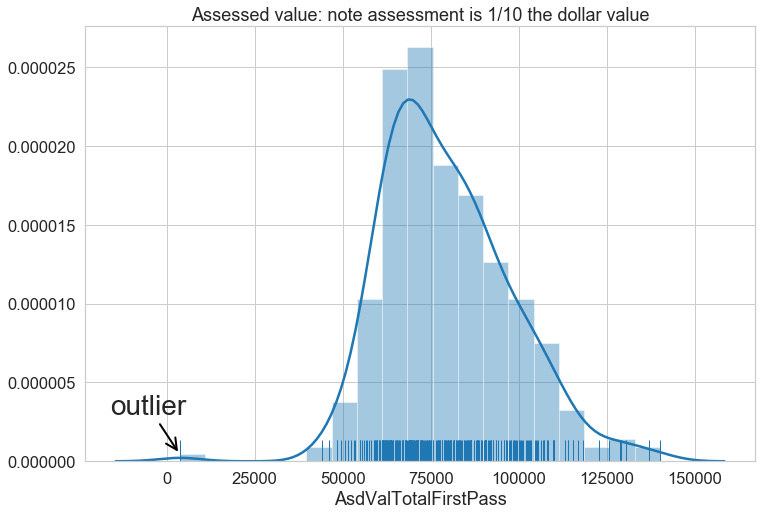

In [11]:
# Ignore a deprecation warning that comes from matplotlib.
#import warnings
#warnings.filterwarnings("ignore")

# Seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams['figure.figsize'] = (12.0, 8.0)
ax = sns.distplot(df.AsdValTotalFirstPass, rug=True)
ax.set_title('Assessed value: note assessment is 1/10 the dollar value');
plt.annotate(
    'outlier',  fontsize=28,
    xy=(3500, 5e-7), xytext=(-1.6e4, 3e-6),
    arrowprops=dict(arrowstyle='->', lw=2, color="k")
);

Overall, the house values are concetrated near "AsdValTotalFirstPass" = 75000, meaning the houses in this size and age range are worth around 10 x 75000 = three quarters of a million dollars right now.

There's one outlier at the low end, a 2-story house in Oak Park that's near Frank Lloyd Wright's house, over 62 years old, and "AsdValTotalFirstPass" below 5,000 (meaning a market price below $50k). Sounds suspect. Out of curiosity, see what makes it an outlier:

1. Get the PIN.
2. Look it up online and see why it's 10x lower than any other value.

In [12]:
df[df.AsdValTotalFirstPass < 5000]

,,Age,Apts,AsdValBldgCertified,AsdValBldgFirstPass,AsdValCurYear,AsdValLandCertified,AsdValLandFirstPass,AsdValPrevYear,AsdValTotalCertified,AsdValTotalFirstPass,...,HalfBaths,MktValCurrYear,MktValPrevYear,NBHD,PrevYear,ResType,SqFt,Taxcode,Township,Use
PIN,Address,,,,,,,,,,,,,,,,,,,,,
16-07-105-030-0000,339 N OAK PARK AVE,129,0,3657,3657,2018 Assessor Certified,122,122,2017,3779,3779,...,0,37790,37790,70,2017,Two Story,11020,27001,Oak Park,Single Family


Aha! It is <a href="https://www.hemingwaybirthplace.com/">Ernest Hemingway's birthplace</a>, at 339 N. Oak Park Ave. Also a museum. Cool, but we should remove it from the dataset.

<figure style="margin-top:1em">
    <figcaption style="text-align:center"><a href="http://www.cookcountyassessor.com/Property.aspx?mode=details&pin=16071050300000">PIN 16-07-105-030-0000</a>, assessed at $37k<br/>(link has no https)</figcaption>
<img src="http://www.cookcountyassessor.com/PropertyImage.aspx?pin=16071050300000" alt="Photo of Hemingway's birthplace"></img>
</figure>

#### Observations about the other numerical columns

Plot everything else just to see. Place the chosen Y-value "AsdValTotalFirstPass" at the top to make it easier to find by prepending it to the list of other variables, and exclude all other "AsdVal/MktVal" columns.

It's OK that the plots are tiny because we're just looking for:

- Trends:
    - Not much correlation between age and assessed value.
    - High correlation between the assessed value and both
      land area and building square feet ("SqFt", "BldgSqFt").
- Bunching:
    - Bunching up near a value suggests the need for a log-transformation.
    - The land area ("SqFt") has some bunching. This is interesting
      and may hint at of why the assessor's office went to a
      log-linear assesment model this year.
- Outliers:
    - You can see Hemingway's birthplace as the outlier dot
      on the bottom with the low assessed value on all the
      charts across the top row.
    - Also one property has very tiny "BldgSqFt".
      (558 square feet. But its assessed value is above median).
      I looked it up, and it's just a typo. The assessment is
      in line with the actual size. I'm not posting
      the PIN because actual humans live there.

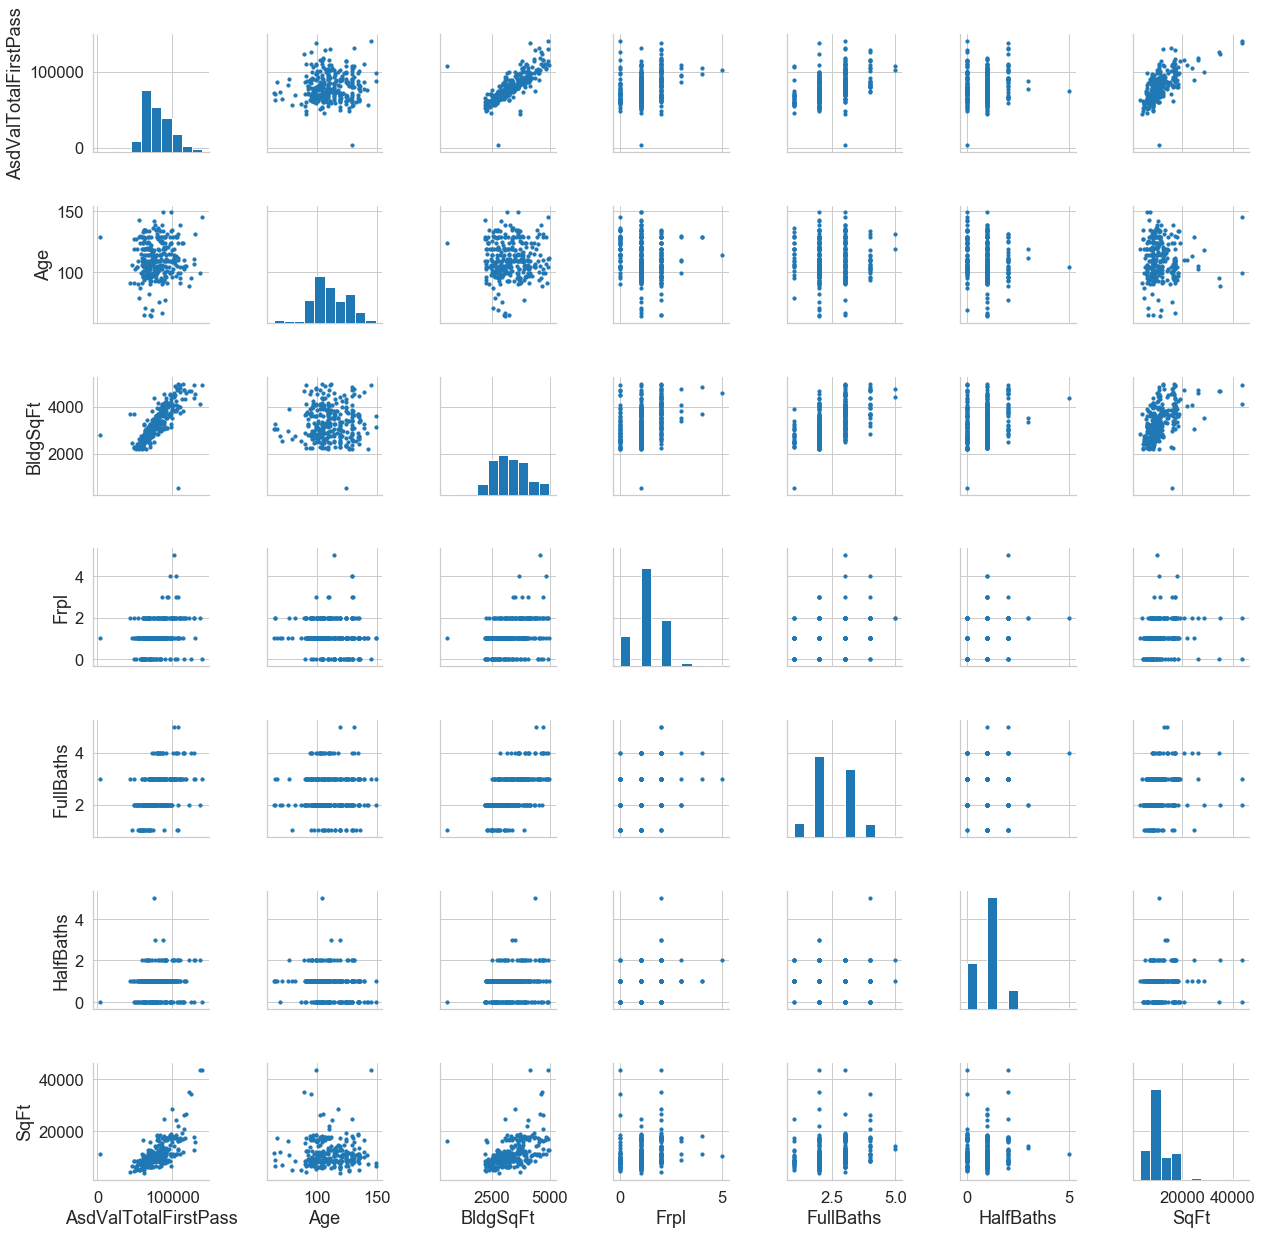

In [13]:
numerical_cols = df[keep_cols].select_dtypes('number').columns
look_at_cols = (
    ['AsdValTotalFirstPass'] +
    [c for c in numerical_cols if 'Val' not in c]
)
plt.rcParams['figure.figsize'] = (12, 12)
g = sns.PairGrid(df[look_at_cols]);
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, s=10)

#### Observations about the categorical columns

Some categories have very few observations. Rather than merge them into an "other" category, just omit the rows (less than 10 rows to remove).

- "ExtConst" has very few "N/A" entries. Just omit those rows.
- "ResType" has very few entries other than "Two Story", which makes sense since we selected a category with two stories. Omit the other entries since there are too few to model well.
- "Use" has one single entry that is "Multi Family". Omit that row.

Both "ResType" and "Use" will have only one entry after we omit the rows with rare entries. So we can also omit those columns.

In [14]:
def summarize_col(colname):
    print('~~', colname, '~~')
    print('{}\n'.format(df[colname].value_counts()))

summarize_col('ExtConst')
summarize_col('ResType')
summarize_col('Use')

~~ ExtConst ~~
Frame            119
Stucco            82
Masonry           62
Frame/Masonry     28
N/A                6
Name: ExtConst, dtype: int64

~~ ResType ~~
Two Story      288
N/A              6
Three Story      3
Name: ResType, dtype: int64

~~ Use ~~
Single Family    290
N/A                6
Multi Family       1
Name: Use, dtype: int64



### Data cleaning summary

- Two outliers will be masked from the model: Hemingway's birthplace and the typo-square-feet house.
- Entries from three columns with very few observations will be masked: "ExtConst", "ResType", and "Use".
- There are 10 or so columns with values that never change, which we're excluding too.


Use masks to preserve the original dataset.

In [15]:
print("Create masks. df shape:", df.shape)

masks = dict(
    # Mask for Hemingway's house
    hemingways_house = df.AsdValTotalFirstPass < 5000,
    # Mask for the random house that has a typo square feet
    typo_house = df.BldgSqFt < 600,
    # Mask for the expensive houses that may be because
    # Frank Lloyd Wright designed them (?)
    expensive_houses = df.AsdValTotalFirstPass > 140000,
    # Mask for the rows with very few different categories
    excluded = (
        (df.ExtConst == "N/A") |
        (df.ResType != "Two Story") |
        (df.Use != "Single Family")
    )
)

# Combine masks
masked = (
    masks['hemingways_house'] |
    masks['typo_house'] |
    masks['expensive_houses'] |
    masks['excluded']
)
keep_cols = df[~masked].columns[df.nunique() > 1]

print("Done.")
print("Without masked data, df shape:", df[~masked][keep_cols].shape)

Create masks. df shape: (297, 34)
Done.
Without masked data, df shape: (285, 21)


### First models

The assessed value has a lot to do with the building square feet and the land area, so the first model will look at only those variables.

#### Q: Why do this before adding the categorical variables?<br/>A:

1. Actually I tried with all the variables first and the model sucked (the coefficients didn't make sense), but showing all the trial &amp; error is boring in a blog post.
2. Since visually there was such strong correlation between the "SqFt" + "BldgSqFt" and the assessed value, it's not a bad idea to try the model with just those two as a baseline anyway.
3. You can plot the categorical variables against the residuals from the first model to help identify which ones to include.


#### Linear regression
The reason to use the `statsmodels` library instead of `scikit-learn` is to get the rich summary that comes along with the regression. For R users, this is the library that gives you what you'd expect.

In [16]:
formula = 'AsdValTotalFirstPass ~ BldgSqFt + SqFt - 1'
linear_areas_only = smf.ols(formula=formula, data=df[~masked]).fit()
linear_areas_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     AsdValTotalFirstPass   R-squared:                       0.992
Model:                              OLS   Adj. R-squared:                  0.992
Method:                   Least Squares   F-statistic:                 1.806e+04
Date:                  Tue, 21 Aug 2018   Prob (F-statistic):          3.39e-299
Time:                          16:19:28   Log-Likelihood:                -2934.3
No. Observations:                   285   AIC:                             5873.
Df Residuals:                       283   BIC:                             5880.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BldgSqFt      19.8396      0.365     54.296      0.000      19.120      20.559
SqFt           1.1887      0.100     11.839      0.000       0.991       1.386
==============================================================================
Omnibus:                       39.385   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.644
Skew:                          -0.174   Prob(JB):                     2.30e-60
Kurtosis:                       7.796   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log-linear regression
The log-linear model has a lower R-squared value, but visually looks about the same when we plot the results. Maybe it will be more accurate after adding additional categories, and that's why Cook County chose to go with it.

In [17]:
formula = 'np.log(AsdValTotalFirstPass) ~ np.log(BldgSqFt) + np.log(SqFt)'
loglinear_areas_only = smf.ols(formula=formula, data=df[~masked]).fit()
loglinear_areas_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log(AsdValTotalFirstPass)   R-squared:                       0.827
Model:                                      OLS   Adj. R-squared:                  0.826
Method:                           Least Squares   F-statistic:                     675.9
Date:                          Tue, 21 Aug 2018   Prob (F-statistic):          2.65e-108
Time:                                  16:19:32   Log-Likelihood:                 288.29
No. Observations:                           285   AIC:                            -570.6
Df Residuals:                               282   BIC:                            -559.6
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.8542      0.208     18.503      0.000       3.444       4.264
np.log(BldgSqFt)     0.6907      0.031     22.285      0.000       0.630       0.752
np.log(SqFt)         0.1969      0.017     11.780      0.000       0.164       0.230
==============================================================================
Omnibus:                       78.649   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              721.033
Skew:                          -0.810   Prob(JB):                    2.69e-157
Kurtosis:                      10.622   Cond. No.                         494.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Visual check

Both regressions look OK.

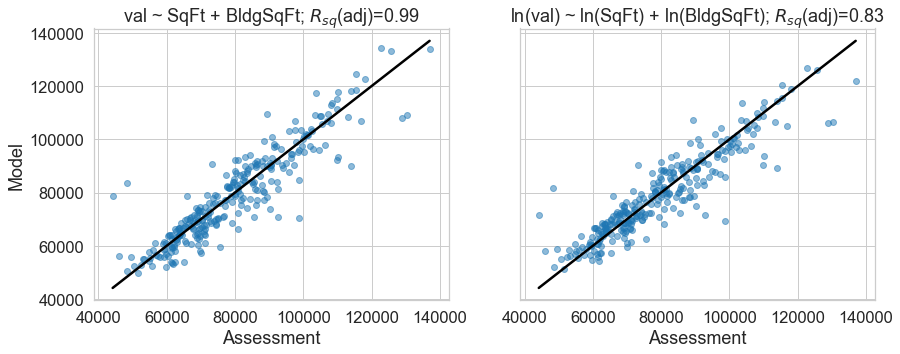

In [18]:
# use toggle
fig, ax = plt.subplots(ncols=2, figsize=(14, 5), sharex=True, sharey=True)
y = df[~masked].AsdValTotalFirstPass
minval = min(min(linear_areas_only.fittedvalues), min(y))
maxval = max(max(linear_areas_only.fittedvalues), max(y))

ax[0].scatter(y, linear_areas_only.fittedvalues, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color="k")
ax[0].set_title(
    "val ~ SqFt + BldgSqFt; $R_{{sq}}$(adj)={:0.2f}"
    .format(linear_areas_only.rsquared_adj)
)
ax[0].set(xlabel="Assessment")
ax[0].set(ylabel="Model")

ax[1].scatter(y, np.exp(loglinear_areas_only.fittedvalues), alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color="k")
ax[1].set_title(
    "ln(val) ~ ln(SqFt) + ln(BldgSqFt); $R_{{sq}}$(adj)={:0.2f}"
    .format(loglinear_areas_only.rsquared_adj)
)
ax[1].set(xlabel="Assessment")

plt.show()

#### Feature engineering for the categorical variables

The remaining categorical variables are "Attic", "Basement", "CentAir", "ExtConst", and "Garage". Between them, there are way too many categories. Even if I coded all of them as binary "yes/no" for an attic, basement, masonry outside, and a garage, that would make 2<sup>5</sup> = 32 possible combinations of categories. With a total of 283 observations, I can at best expect about 283/32 = 8 observations in each category &hellip; probably an overfit.

Visually inspect the categories with boxplots against the original data and against the residuals from the regressions against the lot and building square feet. If there's actually information in the categories that isn't captured by building size (for example, the number of bathrooms in a house correlates pretty well with the building square feet and don't make it into the regression). The following observations summarize interpretation of the five charts below:

- **Omit "Attic"**
    - It doesn't make intiuitive sense that the median property value seems to go down when there's a finished attic.
    - And a lot of the variation that was there at all disappears after the building size is accounted for.
- **Split "Basement" → "Rec room/No rec room"**
    - This makes a little more sense: it is better to have a rec room than to not have one.
    - The median property value for the "None" category also stands out,
      but there are only four houses in it, so they'll just be lumped with "Unfinished".
- **Keep "Central Air" = "Yes/No"**
    - This is the strongest result of all of the categories.
    - It makes sense. Central air was an important factor in picking Mom's house and I'd pay more for it.
- **Omit "External Construction"**
    - The categories are evenly distributed, but the results are hard to interpret.
    - Actually, I tried adding this category in a model and it didn't improve the outcome
      (see the F-tests after this section).
-  **Omit "Garage"**
    - It has 11 distinct categories, which is way too many.
    - And "None" is apparently better than almost everything but a 3-car garage which makes no sense to me.
    - There's not even a clear pattern of preference for attached vs. detached garages.

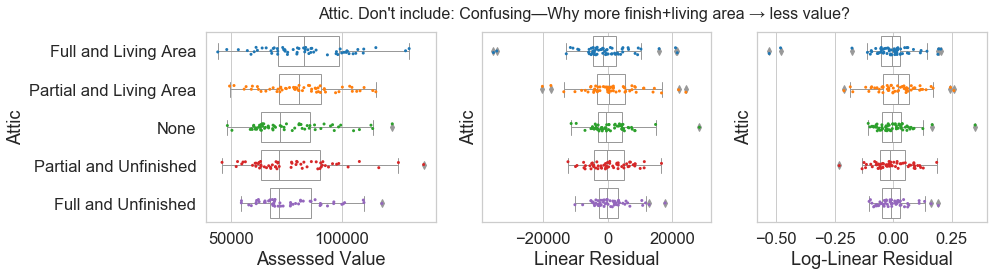

In [19]:
def make_boxplot(colname):
    ycol = 'AsdValTotalFirstPass'
    order = (
        df[~masked].groupby(colname)[ycol].median()
        .sort_values(ascending=False)
        .index
    )
    x = df[~masked][ycol]
    y = df[~masked][colname]
    figsize = (14, 1 + .5 * len(order))
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=figsize, sharey=True)
    sns.boxplot(x=x, y=y, color="white", order=order, ax=ax0, linewidth=1);
    sns.stripplot(x=x, y=y, jitter=True, order=order, ax=ax0, s=3);
    ax0.set_xlabel("Assessed Value")
    x = linear_areas_only.resid
    sns.boxplot(x=x, y=y, color="white", order=order, ax=ax1, linewidth=1);
    sns.stripplot(x=x, y=y, jitter=True, order=order, ax=ax1, s=3);
    ax1.set_xlabel("Linear Residual")
    x = loglinear_areas_only.resid
    sns.boxplot(x=x, y=y, color="white", order=order, ax=ax2, linewidth=1);
    sns.stripplot(x=x, y=y, jitter=True, order=order, ax=ax2, s=3);
    ax2.set_xlabel("Log-Linear Residual")
    return fig

make_boxplot("Attic")
plt.suptitle(
    "Attic. Don't include: "
    "Confusing—Why more finish+living area → less value?",
    fontsize=16);

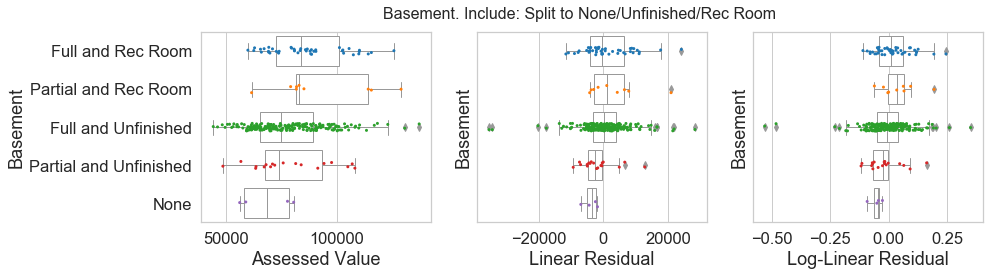

In [20]:
# use toggle
make_boxplot("Basement")
plt.suptitle(
    "Basement. Include: Split to None/Unfinished/Rec Room",
    fontsize=16);

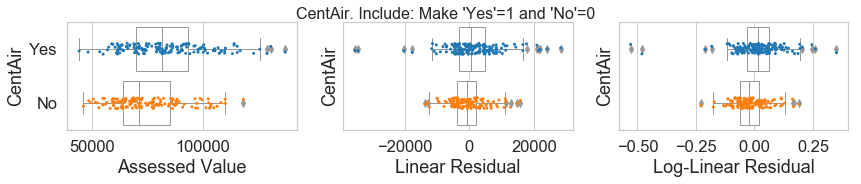

In [21]:
# use toggle
make_boxplot("CentAir")
plt.suptitle(
    "CentAir. Include: Make 'Yes'=1 and 'No'=0",
    fontsize=16);

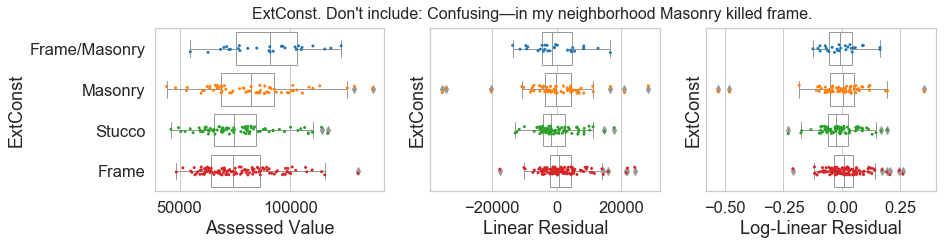

In [22]:
# use toggle
make_boxplot("ExtConst")
plt.suptitle(
    "ExtConst. Don't include: "
    "Confusing—in my neighborhood Masonry killed frame.",
    fontsize=16);

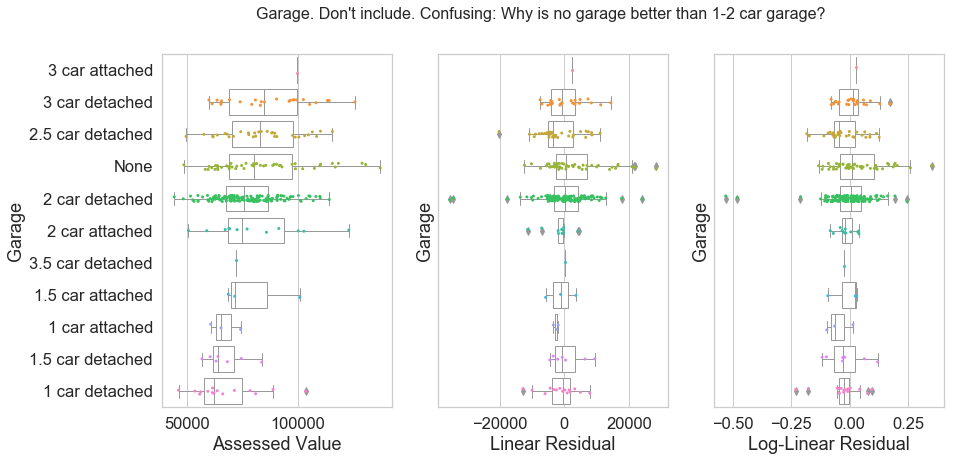

In [23]:
# use toggle
make_boxplot("Garage")
plt.suptitle(
    "Garage. Don't include. Confusing: "
    "Why is no garage better than 1-2 car garage?",
    fontsize=16);

#### Feature engineering part II—check for significance using the F-test

An alternative to (or a confirmation of) the visualizations can be an F-test of a model with versus without a column. The next code compares different models via the F-test. A good F-statistic is large, which will make the p-value small, and mean that the additional variable(s) made a difference in the model. The form of the result is:

(F-statistic, p-value, Δ degrees of freedom)

In [25]:
df['RecRoom'] = df.Basement.str.contains('Rec Room')
models = {}

for x in ('CentAir', 'RecRoom', 'ExtConst', 'CentAir + RecRoom'):
    formula = 'AsdValTotalFirstPass ~ BldgSqFt + SqFt + ' + x
    models[x] = smf.ols(formula=formula, data=df[~masked]).fit()
    print(formula)
    print('F-test vs just the SqFt terms:', models[x].compare_f_test(linear_areas_only))
    print()
 
print("Also compare 'CentAir + RecRoom' with just 'CentAir'")
print(models['CentAir + RecRoom'].compare_f_test(models['CentAir']))

AsdValTotalFirstPass ~ BldgSqFt + SqFt + CentAir
F-test vs just the SqFt terms: (16.32670372298167, 1.9588967590333282e-07, 2.0)

AsdValTotalFirstPass ~ BldgSqFt + SqFt + RecRoom
F-test vs just the SqFt terms: (13.441112751290575, 2.6619459642486806e-06, 2.0)

AsdValTotalFirstPass ~ BldgSqFt + SqFt + ExtConst
F-test vs just the SqFt terms: (6.3633758872080035, 6.50336405290887e-05, 4.0)

AsdValTotalFirstPass ~ BldgSqFt + SqFt + CentAir + RecRoom
F-test vs just the SqFt terms: (11.996666049352182, 2.0621199538397677e-07, 3.0)

Also compare 'CentAir + RecRoom' with just 'CentAir'
(3.0933360572571122, 0.07970581062273667, 1.0)


#### 'Square Feet + Central Air' has the largest F-statistic

Plus, that final F-test comparing the model with both "CentAir + RecRoom" to the one with "CentAir" fails to add that much of a benefit (the p-value is .079), so we pick the model with both Square Feet terms and Central Air, and no other additional categories. The summary of the model fit, shown below, warns there's a high condition number and thus multicollinearity in the model, but I am not concerned. It is probably because the square feet columns are multiple orders of magnitude larger than the True/False value of "CentAir".

In [26]:
linear_areas_with_CentAir = models['CentAir']
linear_areas_with_CentAir.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     AsdValTotalFirstPass   R-squared:                       0.843
Model:                              OLS   Adj. R-squared:                  0.841
Method:                   Least Squares   F-statistic:                     502.7
Date:                  Tue, 21 Aug 2018   Prob (F-statistic):          1.37e-112
Time:                          16:22:19   Log-Likelihood:                -2918.7
No. Observations:                   285   AIC:                             5845.
Df Residuals:                       281   BIC:                             5860.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9492.7430   2016.586      4.707      0.000    5523.210    1.35e+04
CentAir[T.Yes]  2667.8434    832.107      3.206      0.002    1029.890    4305.797
BldgSqFt          16.4672      0.718     22.932      0.000      15.054      17.881
SqFt               1.2435      0.096     12.972      0.000       1.055       1.432
==============================================================================
Omnibus:                       45.647   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.937
Skew:                          -0.099   Prob(JB):                     1.32e-95
Kurtosis:                       9.063   Cond. No.                     6.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Make the log-linear model

The log-linear model will follow the same form as the linear one. Now that the log has been taken of the square feet values, there isn't a condition number warning.

In [28]:
# Log-linear
formula = 'np.log(AsdValTotalFirstPass) ~ np.log(BldgSqFt) + np.log(SqFt) + CentAir'
loglinear_areas_with_CentAir = smf.ols(formula=formula, data=df[~masked]).fit()
loglinear_areas_with_CentAir.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log(AsdValTotalFirstPass)   R-squared:                       0.834
Model:                                      OLS   Adj. R-squared:                  0.833
Method:                           Least Squares   F-statistic:                     471.6
Date:                          Tue, 21 Aug 2018   Prob (F-statistic):          2.52e-109
Time:                                  16:22:50   Log-Likelihood:                 294.11
No. Observations:                           285   AIC:                            -580.2
Df Residuals:                               281   BIC:                            -565.6
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9859      0.208     19.159      0.000       3.576       4.395
CentAir[T.Yes]       0.0364      0.011      3.423      0.001       0.015       0.057
np.log(BldgSqFt)     0.6648      0.031     21.201      0.000       0.603       0.726
np.log(SqFt)         0.2033      0.017     12.310      0.000       0.171       0.236
==============================================================================
Omnibus:                       96.004   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.956
Skew:                          -1.037   Prob(JB):                    1.60e-213
Kurtosis:                      11.844   Cond. No.                         503.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Visually inspect the models.

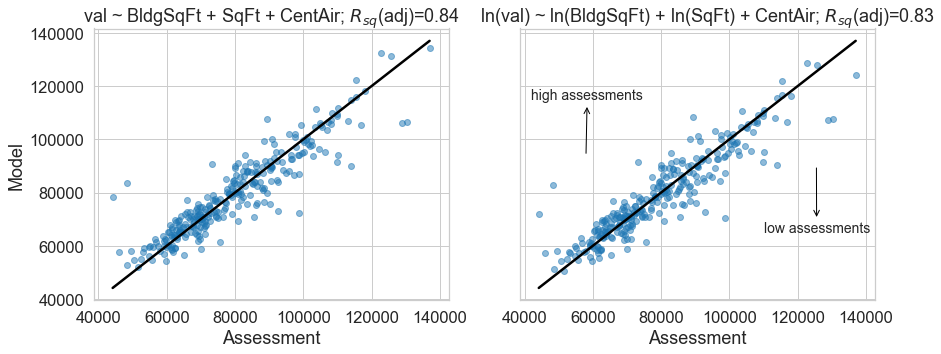

In [29]:
# use toggle
fig, ax = plt.subplots(ncols=2, figsize=(14, 5), sharex=True, sharey=True)
y = df[~masked].AsdValTotalFirstPass

minval = min(min(linear_areas_with_CentAir.fittedvalues), min(y))
maxval = max(max(linear_areas_with_CentAir.fittedvalues), max(y))

ax[0].scatter(y, linear_areas_with_CentAir.fittedvalues, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color="k")
ax[0].set_title(
    "val ~ BldgSqFt + SqFt + CentAir; $R_{{sq}}$(adj)={:0.2f}"
    .format(linear_areas_with_CentAir.rsquared_adj)
)
ax[0].set(xlabel="Assessment")
ax[0].set(ylabel="Model")

ax[1].scatter(y, np.exp(loglinear_areas_with_CentAir.fittedvalues), alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color="k")
ax[1].set_title(
    "    ln(val) ~ ln(BldgSqFt) + ln(SqFt) + CentAir; $R_{{sq}}$(adj)={:0.2f}"
    .format(loglinear_areas_with_CentAir.rsquared_adj)
)
ax[1].set(xlabel="Assessment")
ax[1].annotate(
    'high assessments',  fontsize=14,
    xy=(58000, 94000), xytext=(42000, 115000),
    arrowprops=dict(arrowstyle='<-', lw=1, color='k')
);
ax[1].annotate(
    'low assessments',  fontsize=14,
    xy=(125500, 90000), xytext=(110000, 65000),
    arrowprops=dict(arrowstyle='<-', lw=1, color='k')
);

plt.show()

## Interpret the models

Don't use these numbers because I rounded them a ton to make it easier to write, but for the linear model, a two-story house near Frank Lloyd Wright's, that's around the same size and age is about:

- &#36;95k as a baseline (intercept)
- plus &#36;27k for central air
- plus about &#36;16.5k per 100 square feet of building
- plus about &#36;135k per quarter acre of land (about 12 dollars/square foot; 10,890 square feet/quarter acre)


The log-linear model is harder to interpret because it's multiplicative, but that's the new choice for Cook County.  With this model, a two-story house near Frank Lloyd Wright's, that's around the same size and age is about:

- $538 as a baseline
- times about 13500 per quarter acre of land (~1.2 per square foot)
- times about 190 per 100 square feet of building
- times about 1.03 if it has central air


## Use the model to identify the best houses to contest your assessment

First, if your house is assessed below the model value, you're in a bit of a bind and will need to explain it away with other data (by pointing out similarly priced houses have a pool or a better driveway than yours or something&hellip;I'm not a pro at this). But if your house is assessed above the model value, then you have math on your side.

At this point, I put the model values into the data frame, wrote it to an Excel file, and used Excel to sort through the houses and highlight ones that were similar to Mom's. The goal is to find houses that are a little better than yours (building square foot, age, number of bathrooms), and still somehow are priced below yours, aided by the model. If you run the code below, you will have all the data you pulled from the internet, plus the model fitted values in a file called 'house_model.csv' in the same folder where you put the Jupyter notebook.

In [30]:
df.assign(
    linearModel=linear_areas_with_CentAir.fittedvalues,
    linearResiduals=linear_areas_with_CentAir.resid,
    loglinearModel=loglinear_areas_with_CentAir.fittedvalues,
    loglinearResiduals=loglinear_areas_with_CentAir.resid
).to_csv('house_model.csv')

## Profit! (well, save) &hellip; and share!

If you save some money using this code, share the love + tell a friend! And consider donating a couple of those bucks to a local charity <span class="red">♥</span> since you'd have otherwise given all those doughnuts to Uncle Sam.

<a href="http://bbbschgo.org/">Big Brothers/Big Sisters of Chicago (no https)</a> and <a href="https://www.chicagosfoodbank.org/">Chicago Food Bank</a> love you!

#### The end.

### Python libraries used in this notebook

To run Selenium, you also need a web browser and driver interface to Python. I used <a href="https://www.mozilla.org/en-US/firefox/new/">Firefox</a> and <a href="https://github.com/mozilla/geckodriver">Geckodriver</a>. Geckodriver can be installed effortlessly from <a href="https://anaconda.org/conda-forge/geckodriver">conda-forge</a> if you are using Anaconda (`conda install geckodriver -c conda-forge`), or follow the advice <a href="https://stackoverflow.com/a/48353628">on Stackoverflow</a> without it. The rest of the dependencies are regular Python packages, listed below:

In [31]:
import sys, platform, IPython, lxml, pandas as pd, numpy as np, seaborn as sns, selenium as se, statsmodels
print("This notebook was created on an %s computer running OSX %s and using:\nPython %s\nIPython %s\nlxml %s\nNumPy %s\nPandas %s\nSeaborn %s\nSelenium %s\nStatsModels %s\n" % (platform.machine(), platform.mac_ver()[0], sys.version[:5], IPython.__version__, '.'.join(str(i) for i in lxml.etree.LXML_VERSION), np.__version__, pd.__version__, sns.__version__, se.__version__, statsmodels.__version__))

This notebook was created on an x86_64 computer running OSX 10.13.6 and using:
Python 3.6.6
IPython 6.5.0
lxml 4.2.4.0
NumPy 1.15.0
Pandas 0.23.4
Seaborn 0.9.0
Selenium 3.14.0
StatsModels 0.9.0



### Vocabulary

- **cross-industry standard procedure for data mining (<a href="https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining">CRISP-DM</a>)**<br/>
A popular way to describe the process of data mining, probably because it's much better for people like us to tell our boss that we're on stage X of an acronym-process than it is to say "I'm messing with the data and will get back to you when I figure something out." I added the lighter-color communicate/collaborate/optimize to describe the primary feedback steps because where I have worked the cycle is executed by a team, not by one person.
<figure>
    <!--<figcaption>The cross-industry standard procedure for data mining (<a href="https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining">CRISP-DM</a>)</figcaption>-->
    <img src="crisp-dm.svg" alt="A drawing of the cross-industry standard process for data mining (CRISP-DM). The steps are (1) business understanding, (2) data understanding, (3) data preparation, (4) data modeling, and (5) model evaluation. From there, the process flows either to deployment or back to business understanding for more investigation."></img>
</figure>
- **<a href="https://en.wikipedia.org/wiki/F-test">F-test</a>**<br/>
Statsmodels provides the F-test to compare between nested linear regressison models as a function call: `fitted_model.compare_f_test(nested_fitted_model)`. The test compares the sum of squares of the residuals for the different models and is a useful heuristic for whether adding more variables actually did anything for the model.
- **Feature Engineering**<br/>
Feature engineering is one part of data preparation. The first step is data cleaning: you handle typos in categorical values, and decide what to do with missing ones. Feature engineering is the final step after cleaning, when you convert numerical values like age to categorical ones: (under 12/teenager/adult/senior) or compress multiple categories into fewer ones: (five basement categories → rec room/no rec room), or even turn categorical variables into ordinal ones and use the number instead of the categories: (no basement=0, unfinished=1, rec room=2).


### References

- <a href="http://www.cookcountyassessor.com/Office/News.aspx?id=457">Assessor’s Office improved residential property assessment model unveiled for Tax Year 2018 reassessment (no https)</a><br/>
    Announcement dated 21 May 2018. States that the model is log-linear, that it complies with <a href="https://www.iaao.org/">IAAO</a> standards, and that the Assessor was saddled with a bad system and it wasn't his fault before.
- <a href="https://www.propublica.org/series/the-tax-divide">The Tax Divide</a><br/>
    Article dated 7 December 2017. The <a href="https://features.propublica.org/the-tax-divide/cook-county-commercial-and-industrial-property-tax-assessments/">primary article</a> in this series provides a devastating portrait of incompetence in the County Assessor's office that probably is what cost him his appointment in the following election. It is a collaboration between ProPublica and the Chicago Tribune, and is thrilling for a data person. Here is <a href="https://projects.propublica.org/graphics/the-tax-divide-analysis">their method</a>. They have their data linked from the primary article, but sadly it's paywalled.
    
*All links in this post were accessed on or before August 21, 2018.*